### <div align="center"><b><h3>Spam Email Detector - Personal Project</h3></b></div>

#### Introduction

In this project, I challenge myself to learn the basics of machine learning by solving a real-world inconveniece.

<b>The problem:</b> Spam - we all receive it and know how annoying it can be. What if I could write a script that labels emails as spam if certain patterns are detected?

<b>Solution:</b> Using a database of emails labeled as spam or ham, I will train a machine-learning model to accurately classify emails as potential spam.
At the end, I will create a simple GUI, allowing people without coding knowledge to easily take advantage of the app.

Below I show step-by-step how I went about creating it.

#### 1. Data Loading & Initial Analysis

Firstly, I needed to find a database of pre-categorized emails. Fortunately, this was straightforward thanks to free databases available on the web. 
I used [this one](https://github.com/MWiechmann/enron_spam_data), kindly uploaded by M. Wiechmann, who slightly modified the original resource created by V. Metsis, I. Androutsopoulos, and G. Paliouras.

It's a dataset of over 30k hand-labled emails, about half of which are spam. It's commonly used for learning purposes.

Spam e-mails are labled as <i>Spam</i>, while non-spam e-mails are labled as <i>Ham</b>.

Let's visualize this set better. To do this, I'm using the pandas and matplotlib libraries. I start by loading the data into a variable and then create a graph.

As shown below, the distribution of ham and spam emails is indeed balanced with slightly more labled as spam.

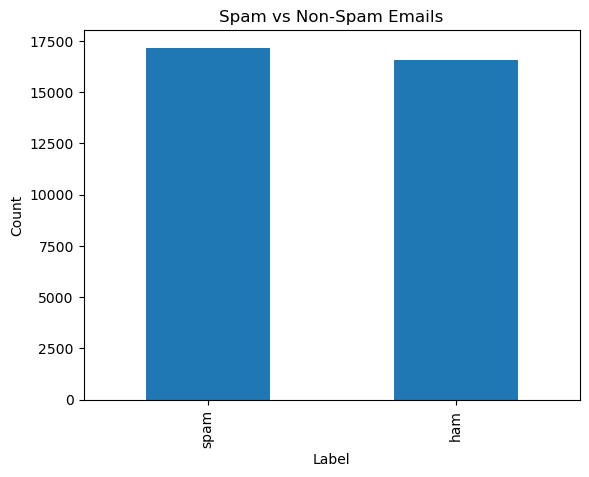

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('enron_spam_data.csv')  # Load the dataset

# Visualize the distribution of spam vs. non-spam emails
data['Spam/Ham'].value_counts().plot(kind='bar')
plt.title('Spam vs Non-Spam Emails')  # Set the plot title
plt.xlabel('Label')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.show()  # Display the plot

#### 2. Data Preparation

As it is right now, the data is not ready to be used as a training set for a machine learning model. It contains some unneccessary columns and is not in a format the model will understand. Let's prepare the data step-by-step.

The CSV I'm using alongside the e-mail's subject and contents, also supplies information about the date it was received and the message's ID. I found both of these values redundant in the training process and because they don't provide any value to the model, I will delete them from the dataset.

Simmilarly, any empty/missing values will be of no help too. That's why I drop them right after.

To do this, I'm using the nltk library. With two simple commands we are one step further to the dataset being ready.

In [ ]:
import nltk

data = data.drop(columns=['Message ID', 'Date'])  # Remove unnecessary columns
data = data.dropna()  # Drop rows with missing values

Now let's focus on the subject and the e-mail's contents. 

Punctuation doesn't help the model either, so let's delete all of it. Also, let's make all the words lowercase to remove case-sensivity.

We can go a step further though. Throughout the e-mail there is going to be a lot of commonly used words, which will be present both in spam and ham messages. These words are called <i> stopwords </i>. A common example of a stopword would be "the", "a" or "is". During this step I will also make sure to exempt these words from the dataset.

The workflow will be simple. Let's disect both the subject and the message into single words (<i>tokenization</i>). 
Then, let's make sure the word is indeed a word (so of a alphanumerical value), is stripped of any punctuation and is not a stopword. 

This proccess is hevily facilitated by the nltk library, which allows me to quickly download and use a list of stopwords in variety of languages.

All of these steps are handled within the <i> preprocess_test() </i> function defined bellow.


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.data.path.append('nltk_data')  # Set NLTK data path (containing stopwords)

def preprocess_text(text):
    text = text.lower().strip()  # Lowercase and strip whitespace
    tokens = word_tokenize(text)  # Tokenize text
    stop_words = set(stopwords.words('english'))  # Set of stopwords
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # Filter tokens
    return ' '.join(tokens)  # Return cleaned text

Now that the function is defined, let's apply it both to the subject and the e-mail's contents. 

This task is achieved very easily with the use of <i>.apply()</i> method.

In [ ]:
# Apply preprocessing to Subject and Message columns
data['cleaned_subject'] = data['Subject'].apply(preprocess_text)
data['cleaned_message'] = data['Message'].apply(preprocess_text)

Finally, let's combined cleaned subjects and cleaned messages into one dataset called <i>X</i>. 

Simmilarly, let's assign all the Spam/Ham labels to the <i>y</i> variable.

In [ ]:
X = data['cleaned_subject'] + ' ' + data['cleaned_message']  # Combine cleaned text
y = data['Spam/Ham']  # Target variable

Altough much has been done, the data is not ready just yet. In order for the machine-learning algorithm to understand it, I need to convert all values into numerical representations.

Let's start with <i>X</i>, so the e-mail subject and contents.
To convert it, I'll be using a TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer.

<b>TODO explain how it works here</b>


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()  # Initialize the TF-IDF vectorizer
X = vectorizer.fit_transform(data['cleaned_subject'] + ' ' + data['cleaned_message'])  # Transform the text data

Similarly, the Spam/Ham categorization also needs to be converted to numerical values, however it's much simpler here as there are only two possible values. 

I'll use a Label Encoder, which assigns the value "0" to Spam and "1" to Ham.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() # Initialize the Label Encoder
y_encoded = le.fit_transform(y)  # Encode labels: "0" for Spam and "1" for Ham

Now, the data is ready to be used for training.

#### 3. Data Splitting

I could use all the data to train the model; however, I would also need a separate set to evaluate its effectiveness. It is a common practice to split the data into a training set and a testing set. This way, one dataset is used for training the model, while the other is used to assess its performance.

Splitting the data is straightforward, thanks to the <i>train_test_split()</i> function, found in a subpackage of the scikit-learn library. 

I simply define the variables and the test size, and appropriate values are automatically assigned.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1)

In the example above, I use 90% of the data to train the model and 10% to test it later.

#### 4. Choosing the machine learning model

i chose multinomial naive bayes because its very skibidi sigma

#### 5.1 Machine Learning Model Training

For this project, I chose the Multinomial Naive Bayes model, which is a common choice due to its effectiveness in text classification (particularly spam detection), ability to handle high-dimensional data, relatively low training time, and real-time prediction capabilities.

The model works by counting the occurrences of each word in an email and using these counts to calculate the probability that the email is spam or ham, based on patterns learned from the training dataset.

Training the model on the pre-processed data is straightforward. I use the .fit() function from the scikit-learn library.

In [5]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()  # Initialize the Multinomial Naive Bayes model

model.fit(X_train, y_train)  # Train the model with training data

y_pred = model.predict(X_test)  # Predict outputs for the test data

#### 5.2 Visualizing How the Model Works

At this point, the model is trained. Although I understand how it works, I wanted to visualize the model's findings. What makes an email more likely to be classified as Spam? And what about Ham?

Using the code below, I create a visualization of the top 10 words indicative of each type of email.

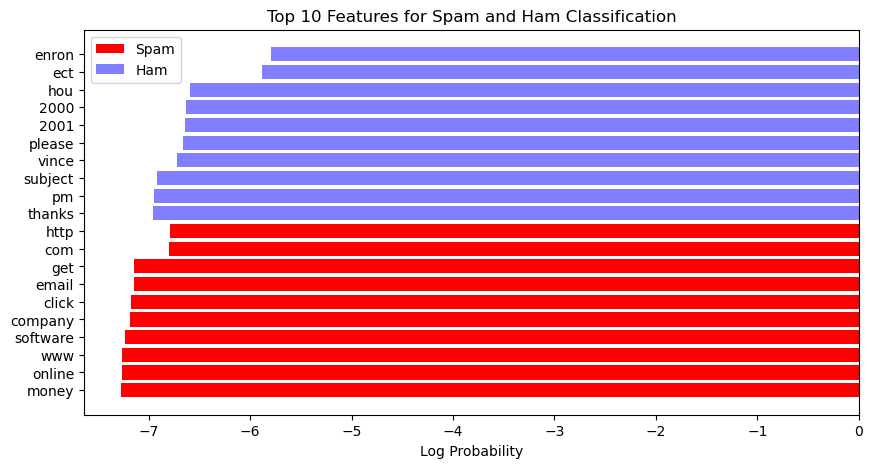

In [6]:
# Import necessary libraries for visualization
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_feature_importance(model, vectorizer):
    feature_names = vectorizer.get_feature_names_out()
    log_probs = model.feature_log_prob_
    
    spam_importance = log_probs[1]
    ham_importance = log_probs[0]
    
    top_n = 10
    spam_indices = np.argsort(spam_importance)[-top_n:]
    ham_indices = np.argsort(ham_importance)[-top_n:]

    plt.figure(figsize=(10, 5))
    plt.barh(feature_names[spam_indices], spam_importance[spam_indices], color='red', label='Spam')
    plt.barh(feature_names[ham_indices], ham_importance[ham_indices], color='blue', label='Ham', alpha=0.5)
    plt.xlabel('Log Probability')
    plt.title(f'Top {top_n} Features for Spam and Ham Classification')
    plt.legend()
    plt.show()

plot_feature_importance(model, vectorizer)


As shown on the graph above, it is evident that Spam emails commonly mention money or companies, contain calls-to-action and are abundant in links.

On the other hand, Ham e-mails seem to have less of a  unified pattern, though we do see that it's common to see a mention of time ("pm") and polite words ("thanks", "please").

#### 6. Initial Model's Evaluation

Awesome! I've got my model up and running. Now it's time to test it's accurracy. Thankfully in the sklearn library there are many built-in functions that make it a breeze.

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)  # Calculate the accuracy of the model
print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(y_test, y_pred)  # Generate the confusion matrix

# Display counts of correct and incorrect predictions for each class
print(f"Spam labeled right/wrong: {conf_matrix[0][0]} / {conf_matrix[0][1]}")
print(f"Ham labeled right/wrong: {conf_matrix[1][1]} / {conf_matrix[1][0]}")

Accuracy: 0.988221081244337
Spam labeled right/wrong: 1638 / 16
Ham labeled right/wrong: 1634 / 23


#### 7. Hyperparameter Tuning Using Randomized Search

Although the model is already trained, it uses default hyperparameters. There is a possibility that we can improve the model's accuracy by tweaking some of these values. One of the most common methods to find optimal hyperparameters is using Randomized Search. This technique randomly samples values from a specified range to identify the best ones.

This process takes some time, as the model needs to be trained and tested repeatedly before reporting the best values.

In [8]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the hyperparameter distribution
param_distributions = {
    'alpha': np.linspace(0.1, 2.0, 10)  # Range of alpha values for optimization
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, 
                                   n_iter=10, scoring='accuracy', cv=3, verbose=1, random_state=42)

# Fit the model to find the best hyperparameters
random_search.fit(X_train, y_train)

# Output the best parameters found
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'alpha': 0.1}


#### 8. Optimized Model's Evaluation

Now, let's evaluate the model's accuracy with the best parameters.

In [9]:
# Get the best model from the randomized search
best_model = random_search.best_estimator_

# Evaluate the test accuracy of the best model
test_accuracy = best_model.score(X_test, y_test)

# Output the test accuracy with the best parameters
print("Test Accuracy with Best Parameters:", test_accuracy)

Test Accuracy with Best Parameters: 0.9912413168227122


As shown above, the Randomized Search technique helped increase the model's accurracy by 0.31%, therefore <b>reducing the error rate by 25.6%</b>.

It's a substantial improvement, bringing the model's accurracy that much closer to perfection.

#### 9. Manual Testing

Now, I'd like to test the model by composing an email myself and observing how it is labeled. I'll start by defining a function that accomplishes this.

In [10]:
def predict_email(subject, message):
    # Preprocess the subject and message
    cleaned_subject = preprocess_text(subject)
    cleaned_message = preprocess_text(message)
    
    # Combine cleaned subject and message
    custom_email = cleaned_subject + ' ' + cleaned_message
    
    # Vectorize the combined email text
    custom_email_vectorized = vectorizer.transform([custom_email]).toarray()
    
    # Make a prediction using the best model
    prediction = best_model.predict(custom_email_vectorized)
    
    # Return the label corresponding to the predicted class
    return le.inverse_transform(prediction)[0]

Everything is ready for testing now. Feel free to modify the inputs and explore how it works!

In [11]:
# Test the email prediction function with a sample subject and message. Try it yourself!
result = predict_email("Buy our latest product!", "We invite you to buy our company's newest product!")

print(f"The email is predicted to be: {result}.")

The email is predicted to be: spam.


In this example the e-mail was correctly labled as <i>spam</i>.

How did the model perform with your input?

#### 10. Saving the Model and the Vectorizer for future use

Now that the model is functioning and I've identified the best parameters, I would like to save it. This way, I don't have to undergo resource-intensive training each time I want to utilize its labeling capabilities. 

This task can be easily accomplished using the <i>joblib</i> library and it's function <i>dump</i>. Let's start by importing it.

In [ ]:
from joblib import dump

Now, let's save both the <i>best_model</i> and the <i>vectorizer</i> using two simple commands shown below.

In [ ]:
# Save the trained model to a file for future use
dump(best_model, 'spam_detection_best_model.joblib')

# Save the vectorizer to a file for later access
dump(vectorizer, 'vectorizer.joblib')